# Generic Brazil Interpolated Yield Surface 

Built curves for 55 observation dates.


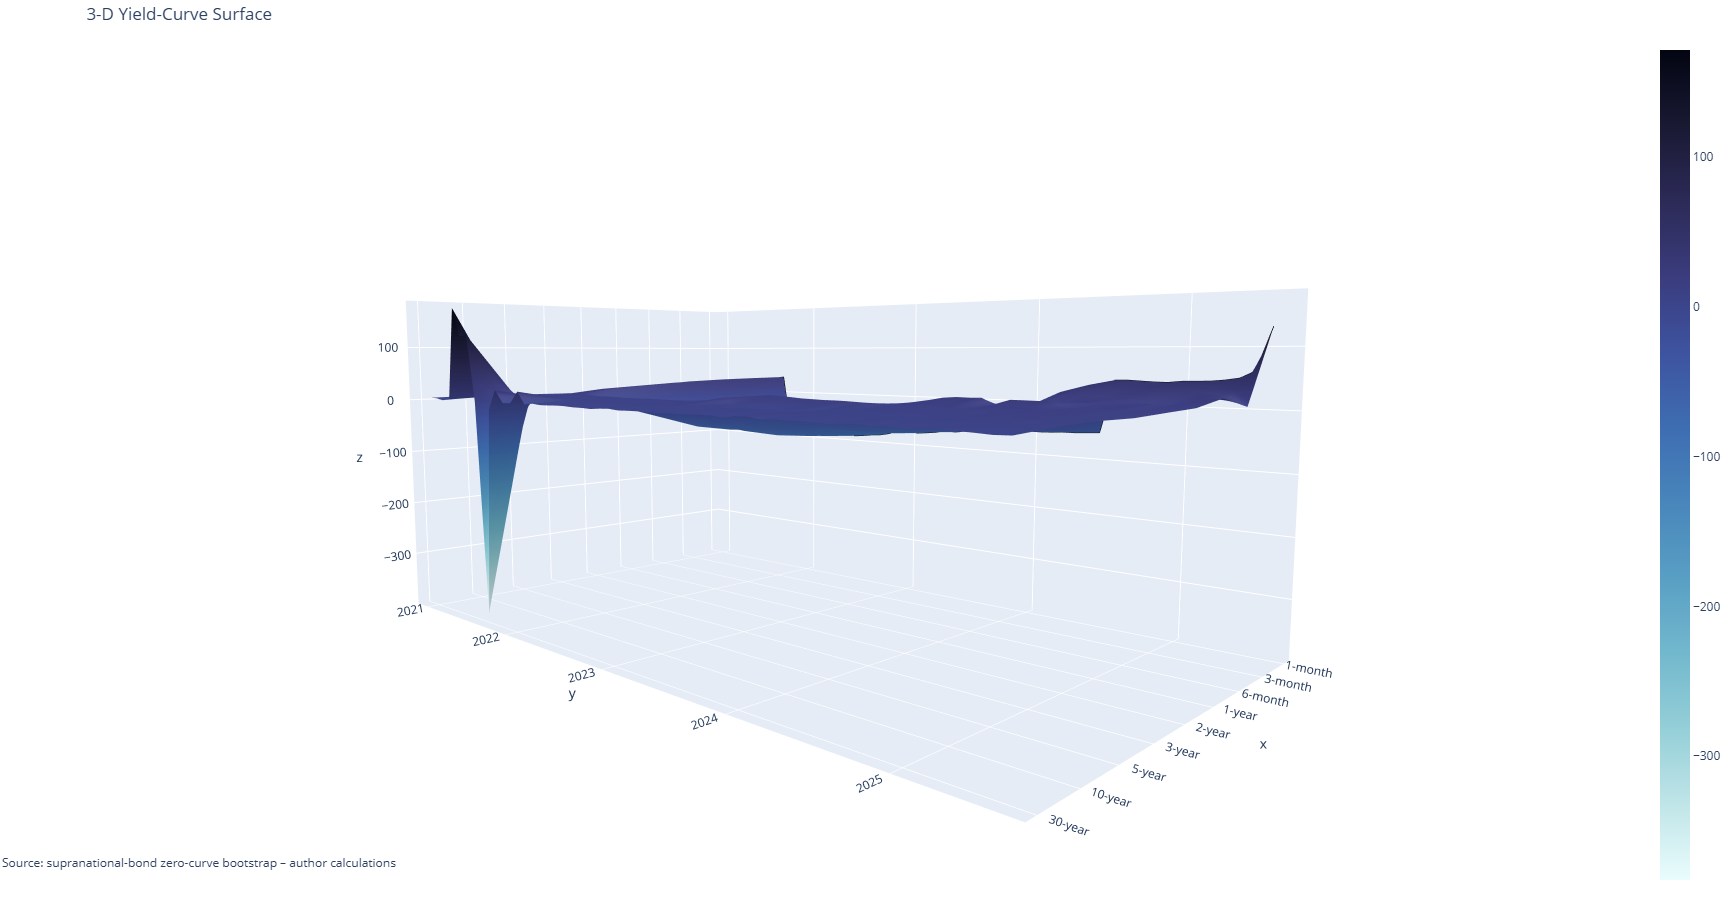

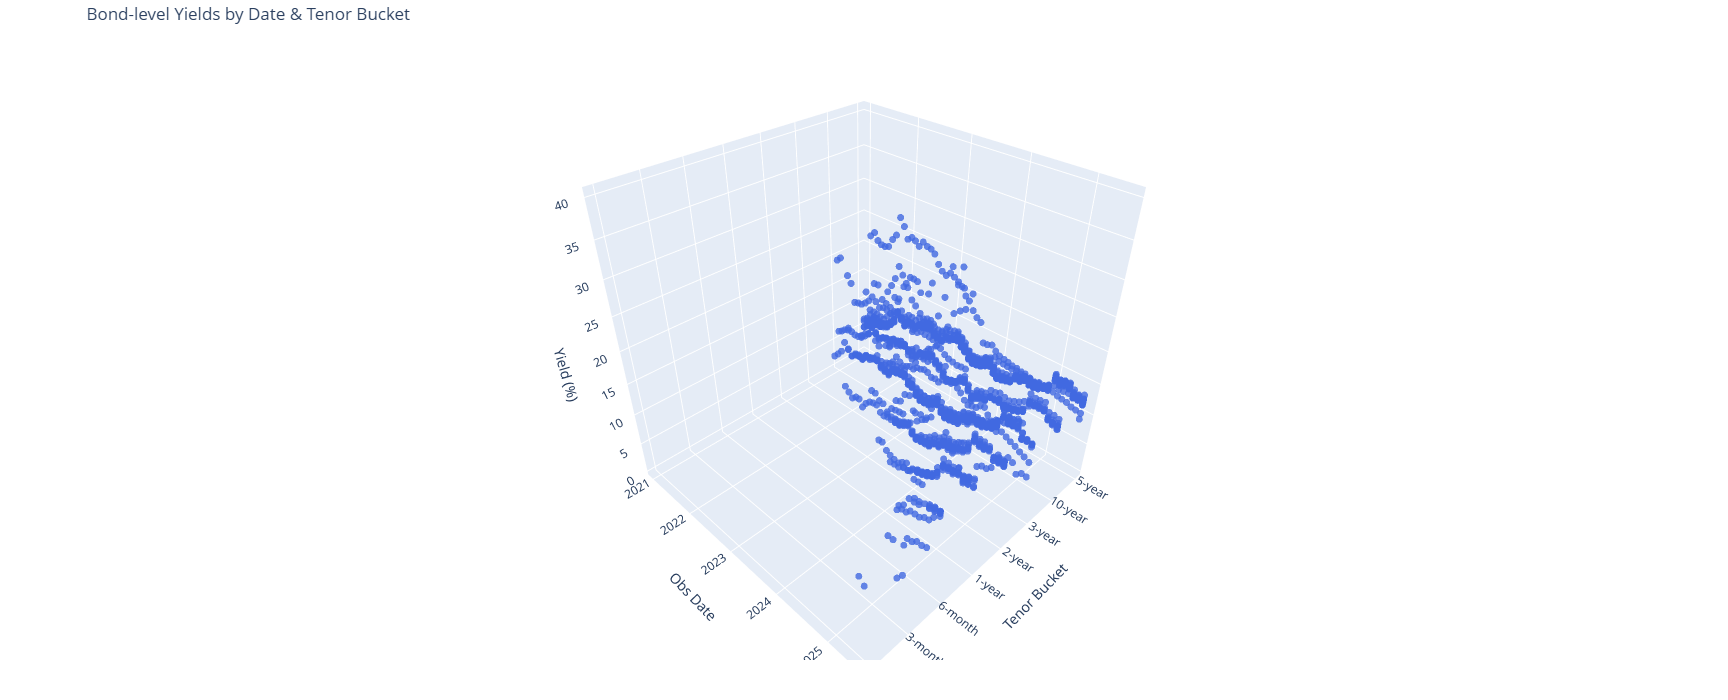

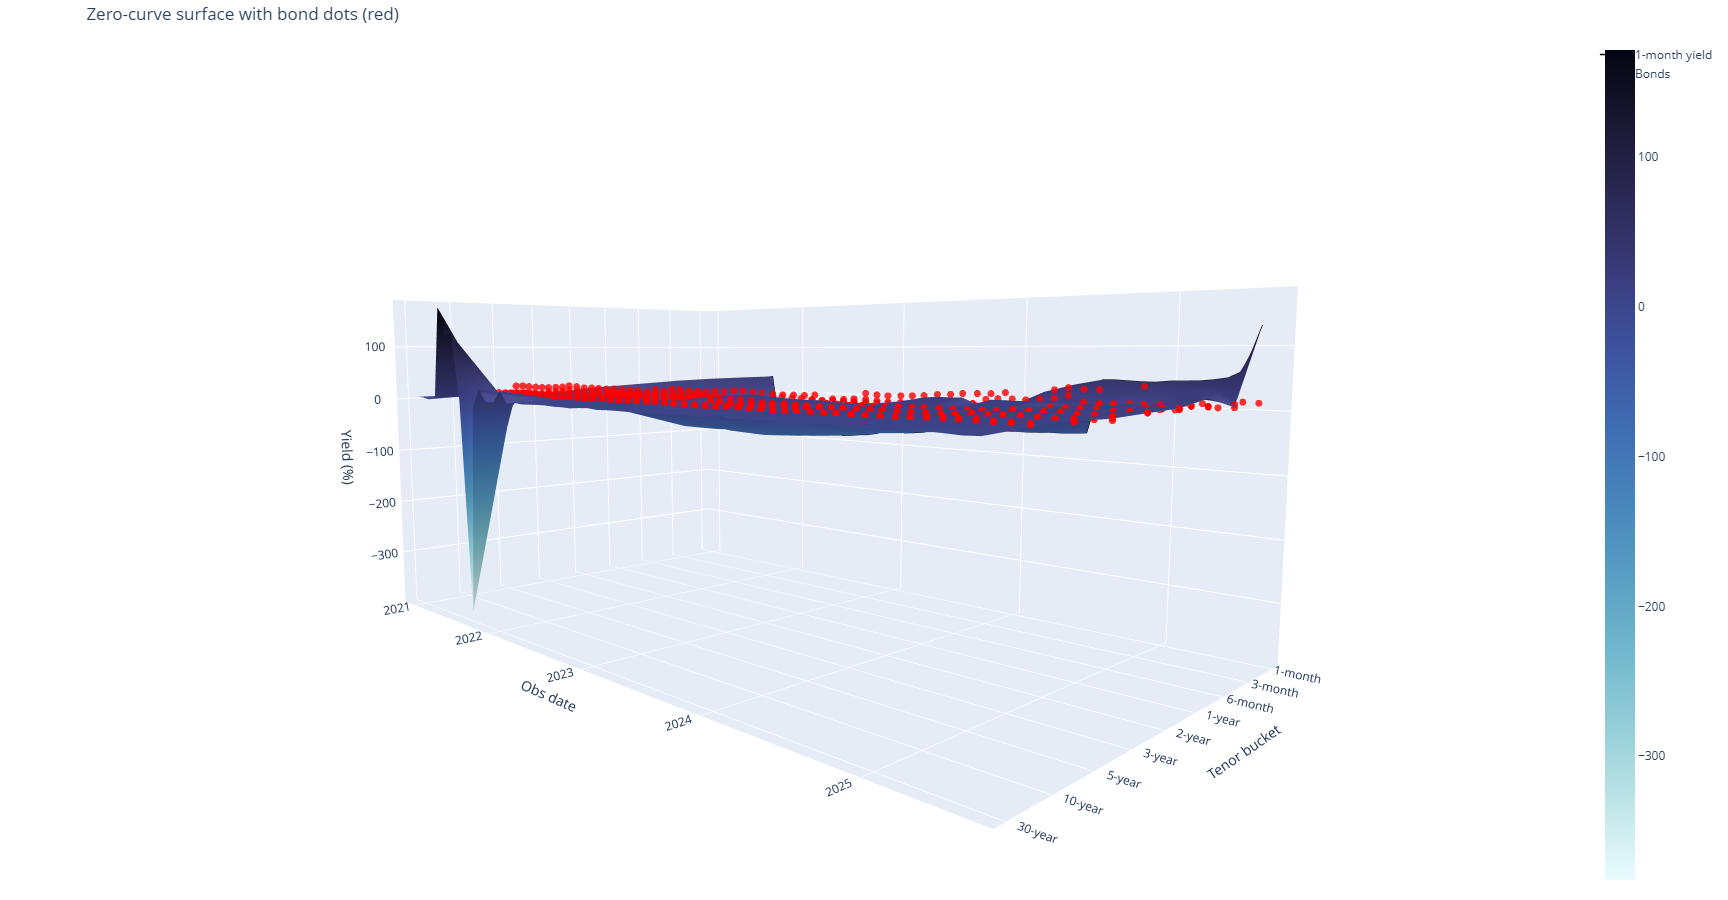

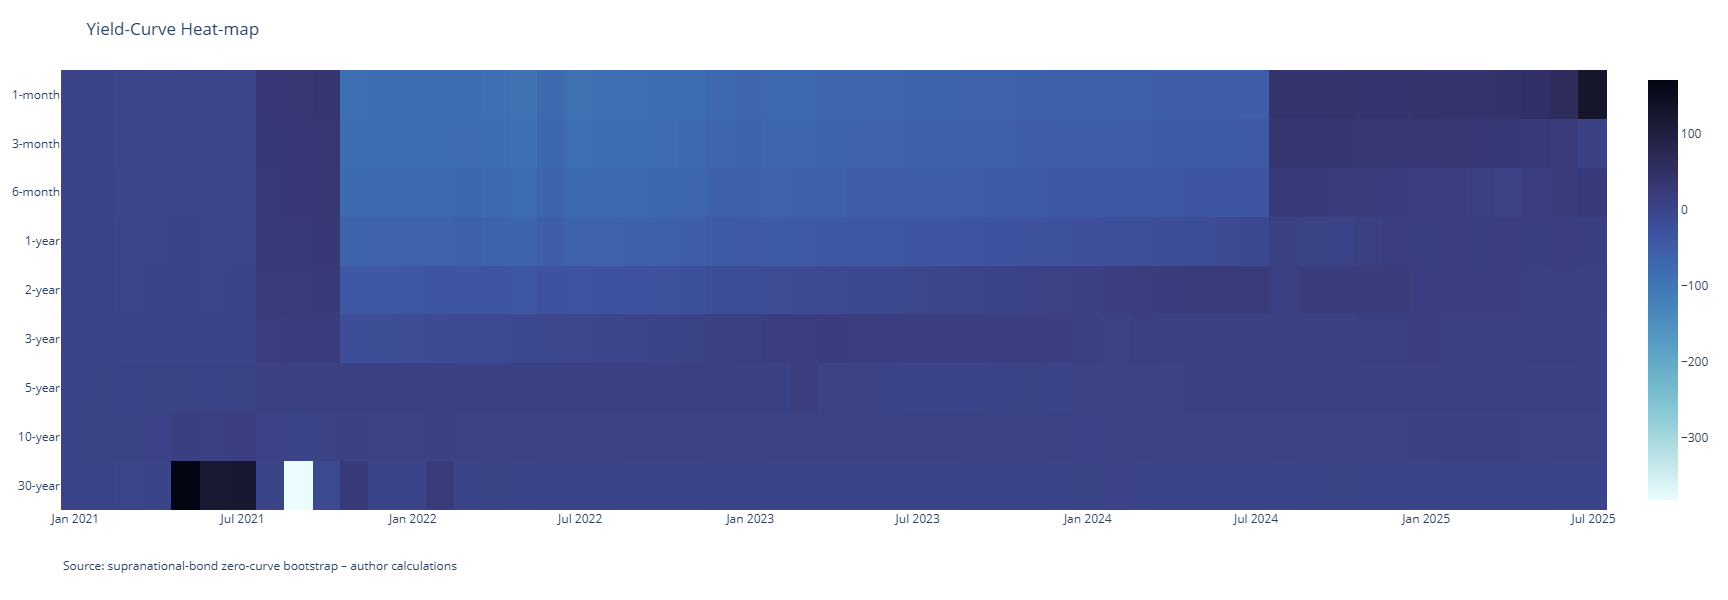

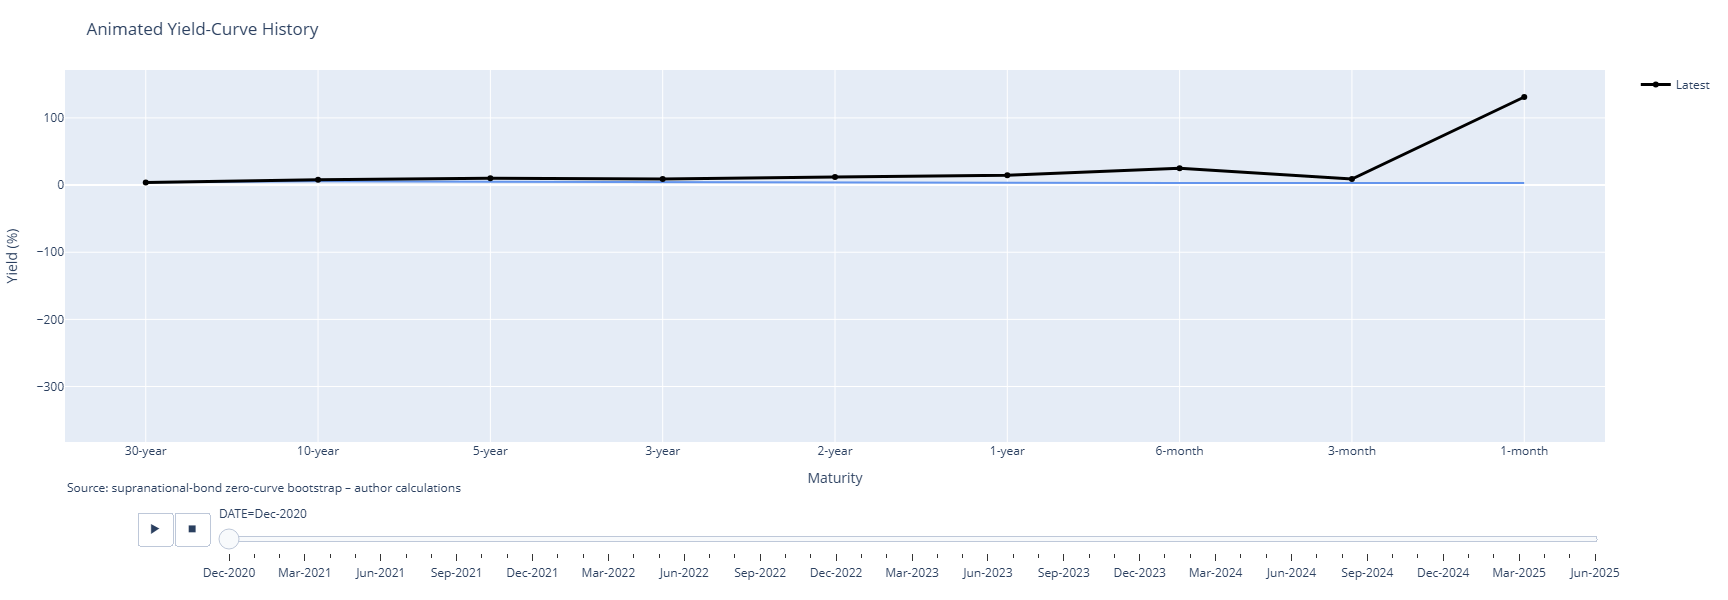

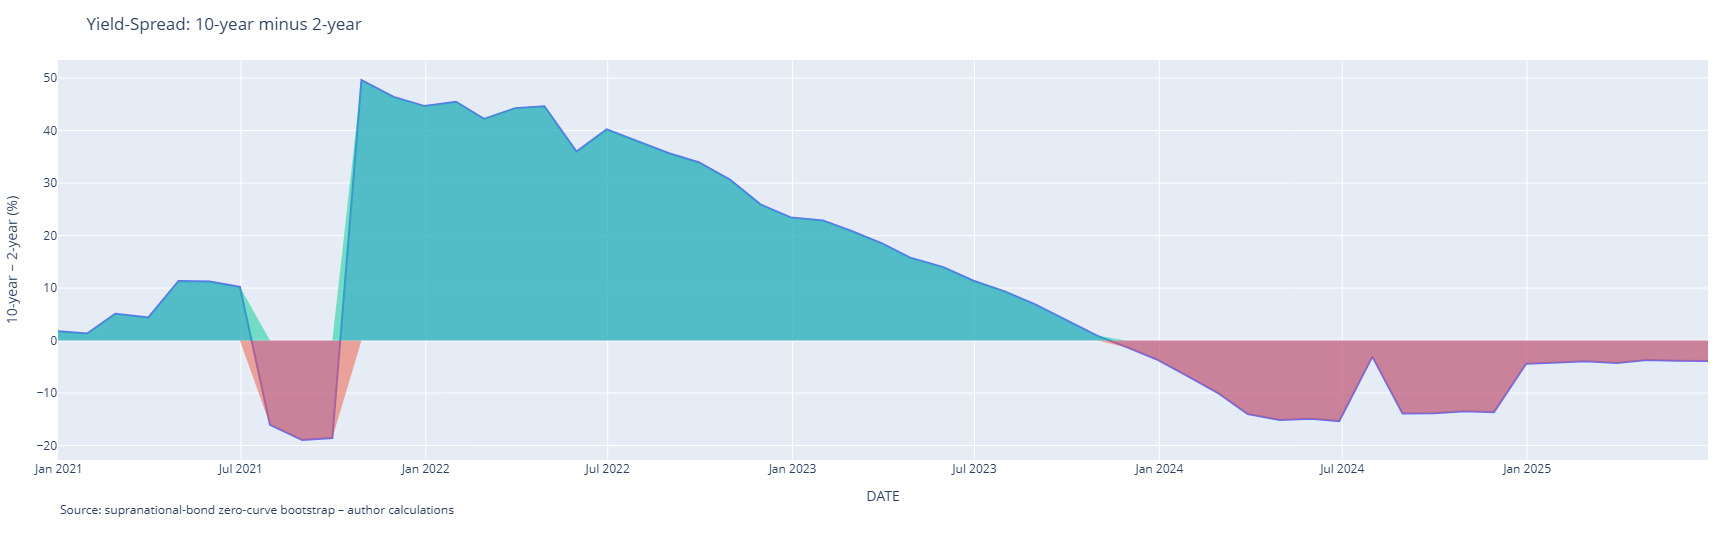

In [1]:
"""
Zero-curve bootstrap → Fed-style table → interactive visuals
"""

# ────────────────────────────────────────────────────────────────
# 1. Imports
# ────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
from pathlib import Path

# finance libs (install / adjust as required)
from calendars.daycounts import DayCounts
from finmath.termstructure.curve_models import CurveBootstrap
from finmath.brazilian_bonds.corporate_bonds import CorpsCalcs1

# optional: SciPy interpolation (fallback to numpy.interp if absent)
try:
    from scipy.interpolate import interp1d
except ImportError:
    interp1d = None
    print("SciPy not found – falling back to numpy.interp (no extrapolation)")

# Plotly for visuals
import plotly.express as px
import plotly.graph_objects as go

# ────────────────────────────────────────────────────────────────
# 1. Globals – audit collector
# ────────────────────────────────────────────────────────────────
AUDIT_LOG: list[pd.DataFrame] = []  # filled inside build_zero_curve

# ────────────────────────────────────────────────────────────────
# 2. Locate repo root & data files
# ────────────────────────────────────────────────────────────────
REPO_ROOT = Path.cwd()
while not (REPO_ROOT / ".git").exists() and REPO_ROOT != REPO_ROOT.parent:
    REPO_ROOT = REPO_ROOT.parent

SUPRA_PATH = REPO_ROOT / "datos_y_modelos" / "Domestic" / "supra.xlsx"
YIELD_PATH = Path("../db/supranational_bonds/ya.xlsx")
ID_COL = "id"     # change here if necessary
DAYCOUNT = DayCounts("bus/252", calendar="cdr_anbima")

# ────────────────────────────────────────────────────────────────
# 3. Static bond characteristics
# ────────────────────────────────────────────────────────────────
bonds_static = pd.read_excel(SUPRA_PATH)
bonds_static["MATURITY"]     = pd.to_datetime(bonds_static["MATURITY"])
bonds_static["FIRST_CPN_DT"] = pd.to_datetime(
    bonds_static["FIRST_CPN_DT"], errors="coerce"
)
bonds_static = (
    bonds_static
      .dropna(subset=["MATURITY"])
      .loc[bonds_static["MATURITY"] >= "2000-01-01"]
      .set_index(ID_COL)
)

# ────────────────────────────────────────────────────────────────
# 4. Historical YAS yield matrix
# ────────────────────────────────────────────────────────────────
ylds = pd.read_excel(YIELD_PATH, sheet_name="ya_values_only")
ylds.rename(columns={ylds.columns[0]: "OBS_DATE"}, inplace=True)
ylds["OBS_DATE"] = pd.to_datetime(ylds["OBS_DATE"])
ylds = ylds.set_index("OBS_DATE").sort_index()

# ────────────────────────────────────────────────────────────────
# 5. Helper functions
# ────────────────────────────────────────────────────────────────
def clean_yield_series(y: pd.Series) -> pd.Series:
    """Return decimal yields with 0 % < y < 40 % and finite."""
    y = pd.to_numeric(y, errors="coerce")
    return y.where((y > 0.0) & (y < 0.40))


def build_zero_curve(ref_date: pd.Timestamp, yld_row: pd.Series) -> pd.Series:
    """
    Bootstrap a zero-curve for *ref_date*.
    Returns Series indexed by time-to-maturity (yrs) with DECIMAL rates.
    """
    df = bonds_static.copy()

    df["YAS_BOND_YLD"] = clean_yield_series(df.index.to_series()
                                            .map(yld_row) / 100.0)  # % → decimal
    df = (
        df.dropna(subset=["YAS_BOND_YLD"])
          .loc[df["MATURITY"].dt.date > ref_date.date()]
    )
    if len(df) < 5:
        raise ValueError("≤ 4 clean bonds – skip")

    # split
    zc_df    = df[df["CPN_TYP"] == "ZERO COUPON"].sort_values("MATURITY")
    fixed_df = df[df["CPN_TYP"] == "FIXED"].sort_values("MATURITY")

    zc_prices, zc_cf = [], []
    for mat, y in zip(zc_df["MATURITY"], zc_df["YAS_BOND_YLD"]):
        b = CorpsCalcs1(expiry=mat.date(), rate=y, ref_date=ref_date)
        zc_prices.append(b.price)
        zc_cf.append(pd.Series(index=[mat.date()], data=[b.principal]))

    fixed_prices, fixed_cf = [], []
    for mat, y, cr, fq, fcd in zip(
        fixed_df["MATURITY"],
        fixed_df["YAS_BOND_YLD"],
        fixed_df["CPN"].astype(float) / 100.0,
        fixed_df["CPN_FREQ"].fillna(1).astype(int),
        fixed_df["FIRST_CPN_DT"],
    ):
        b = CorpsCalcs1(
            expiry   = mat.date(),
            rate     = y,
            coupon_rate = cr,
            freq     = fq,
            ref_date = ref_date,
            first_coupon_date = fcd.date() if pd.notna(fcd) else None,
        )
        fixed_prices.append(b.price)
        fixed_cf.append(b.cash_flows)

    cb = CurveBootstrap(
        prices     = zc_prices + fixed_prices,
        cash_flows = zc_cf     + fixed_cf,
        ref_date   = ref_date,
    )

    
    # --- attach zero rates -------------------------------------------------
    curve = cb.zero_curve  # decimal
    curve_times = np.array([
        DAYCOUNT.tf(ref_date, d) if np.issubdtype(curve.index.dtype, np.datetime64)
        else d for d in curve.index
    ], dtype=float)
    curve_rates = curve.values
    if interp1d:
        fz = interp1d(curve_times, curve_rates, kind="linear",
                      bounds_error=False, fill_value="extrapolate")
        get_zr = lambda t: float(fz(t))
    else:
        get_zr = lambda t: float(np.interp(
            t, curve_times, curve_rates,
            left=curve_rates[0], right=curve_rates[-1]
        ))
    df["ZERO_RATE"] = [
        get_zr(DAYCOUNT.tf(ref_date, m)) for m in df["MATURITY"]
    ]

    # --- store snapshot ----------------------------------------------------
    df["OBS_DATE"] = ref_date.date()
    audit_cols = ["id", "OBS_DATE", "MATURITY", "CPN_TYP", "CPN",
                  "YAS_BOND_YLD", "ZERO_RATE"]
    AUDIT_LOG.append(df.reset_index()[audit_cols])

    
    return cb.zero_curve  # decimals


# ────────────────────────────────────────────────────────────────
# 6. Build zero-rate surface
# ────────────────────────────────────────────────────────────────
surface_rows = []
for obs_date, yld_row in ylds.iterrows():
    try:
        curve = build_zero_curve(obs_date, yld_row)
        ttms  = ([DAYCOUNT.tf(obs_date, d) for d in curve.index]
                 if np.issubdtype(curve.index.dtype, np.datetime64)
                 else curve.index.astype(float))
        surface_rows.append(pd.DataFrame({
            "obs_date":  obs_date,
            "ttm":       ttms,
            "zero_rate": curve.values * 100.0      # → %
        }))
    except ValueError:
        pass

if not surface_rows:
    raise RuntimeError("No curves built – check data/filters")

surface = pd.concat(surface_rows, ignore_index=True)
print(f"Built curves for {surface['obs_date'].nunique()} observation dates.")

# ── consolidate audit snapshots
AUDIT_DF = pd.concat(AUDIT_LOG, ignore_index=True) if AUDIT_LOG else pd.DataFrame()

# ── add DAYS_TO_MATURITY & TENOR_BUCKET
if not AUDIT_DF.empty:
    AUDIT_DF["DAYS_TO_MATURITY"] = (
        pd.to_datetime(AUDIT_DF["MATURITY"]) -
        pd.to_datetime(AUDIT_DF["OBS_DATE"])
    ).dt.days
    AUDIT_DF["TENOR_YRS"] = AUDIT_DF["DAYS_TO_MATURITY"] / 365.25

    TENOR_BRACKETS = {
        "30-year": 30.0, "10-year": 10.0, "5-year": 5.0, "3-year": 3.0,
        "2-year": 2.0, "1-year": 1.0, "6-month": 0.5,
        "3-month": 0.25, "1-month": 1.0/12.0,
    }
    names = list(TENOR_BRACKETS.keys())
    vals  = np.array(list(TENOR_BRACKETS.values()))

    def bucketize(years: float) -> str:
        return names[np.argmin(np.abs(vals - years))]

    AUDIT_DF["TENOR_BUCKET"] = AUDIT_DF["TENOR_YRS"].apply(bucketize)

# ────────────────────────────────────────────────────────────────
# 7. Resample to Fed-style tenors
# ────────────────────────────────────────────────────────────────
TENORS = {
    "30-year": 30.0,
    "10-year": 10.0,
    "5-year":   5.0,
    "3-year":   3.0,
    "2-year":   2.0,
    "1-year":   1.0,
    "6-month":  0.5,
    "3-month":  0.25,
    "1-month":  1.0/12.0,
}

rows = []
for obs_date, grp in surface.groupby("obs_date"):
    x = grp["ttm"].to_numpy(float)
    y = grp["zero_rate"].to_numpy(float)

    if interp1d:
        f = interp1d(x, y, kind="linear",
                     bounds_error=False, fill_value="extrapolate")
        interp = lambda t: float(f(t))
    else:
        interp = lambda t: float(np.interp(t, x, y, left=y[0], right=y[-1]))

    row = {"DATE": obs_date.date()}
    row.update({col: interp(ttm) for col, ttm in TENORS.items()})
    rows.append(row)


yc_table = pd.DataFrame(rows).set_index("DATE").sort_index()



# ────────────────────────────────────────────────────────────────
# 8. Plotting helpers
# ────────────────────────────────────────────────────────────────
def plot_yield_curve_surface(df, source_text=""):
    short_col = df.columns[0]             # line on shortest tenor
    zmin, zmax = df.values.min(), df.values.max()
    fig = go.Figure()
    fig.add_trace(go.Surface(
        x=df.columns, y=df.index, z=df.values,
        colorscale="ice", reversescale=True,
        cmin=zmin, cmax=zmax,
        hovertemplate="<br>Date: %{y}"
                      "<br>Maturity: %{x}"
                      "<br>Yield: %{z:.2f}%<extra></extra>"
    ))
    fig.add_trace(go.Scatter3d(
        x=[short_col]*len(df), y=df.index, z=df[short_col],
        mode="lines", line=dict(color="black", width=1.5),
        name=f"{short_col} yield"
    ))
    fig.update_layout(
        title="3-D Yield-Curve Surface", height=900,
        scene=dict(
            aspectratio=dict(x=1, y=1.75, z=0.75),
            camera=dict(eye=dict(x=1.65, y=1.57, z=0.25))
        ),
        margin=dict(l=0, r=0, t=40, b=10),
        annotations=[dict(text=source_text, x=0, y=0.02,
                          xref="paper", yref="paper", showarrow=False)]
    )
    return fig

def plot_audit_3d(points_df: pd.DataFrame) -> go.Figure:
    """Standalone scatter: x=TENOR_BUCKET, y=OBS_DATE, z=YAS_BOND_YLD."""
    pts = points_df.sort_values("OBS_DATE")
    fig = go.Figure(data=[
        go.Scatter3d(
            x=pts["TENOR_BUCKET"],  # categorical on x
            y=pts["OBS_DATE"],
            z=pts["YAS_BOND_YLD"] * 100,
            mode="markers",
            marker=dict(size=4, color="royalblue", opacity=0.8),
            text=(pts["id"] + "<br>" +
                  pts["CPN_TYP"] + " " + pts["CPN"].astype(str) + "%<br>" +
                  "Mat: " + pts["MATURITY"].astype(str)),
            hovertemplate="<b>%{text}</b><br>Date: %{y}<br>Tenor: %{x}"
                          "<br>Yield: %{z:.2f}%<extra></extra>"
        )
    ])
    fig.update_layout(
        title="Bond-level Yields by Date & Tenor Bucket", height=700,
        scene=dict(xaxis_title="Tenor Bucket", yaxis_title="Obs Date",
                   zaxis_title="Yield (%)"),
        margin=dict(l=20, r=20, t=40, b=40)
    )
    return fig

def plot_surface_with_bonds(df_surface: pd.DataFrame,
                            audit: pd.DataFrame,
                            title: str):
    short = df_surface.columns[0]
    zmin, zmax = df_surface.values.min(), df_surface.values.max()

    fig = go.Figure()
    # surface
    fig.add_trace(go.Surface(
        x=df_surface.columns, y=df_surface.index, z=df_surface.values,
        colorscale="ice", reversescale=True,
        cmin=zmin, cmax=zmax,
        hovertemplate="<br>Date: %{y}<br>Tenor: %{x}<br>Yield: %{z:.2f}%<extra></extra>"
    ))
    # ridge
    fig.add_trace(go.Scatter3d(
        x=[short]*len(df_surface), y=df_surface.index, z=df_surface[short],
        mode="lines", line=dict(color="black", width=1.5),
        name=f"{short} yield"
    ))
    # dots
    fig.add_trace(go.Scatter3d(
        x=audit["TENOR_BUCKET"],
        y=audit["OBS_DATE"],
        z=audit["YAS_BOND_YLD"]*100,
        mode="markers",
        marker=dict(size=4, color="red", opacity=0.8),
        text=(audit["id"] + "<br>" +
              audit["CPN_TYP"] + " " + audit["CPN"].astype(str) + "%<br>" +
              "Mat: " + audit["MATURITY"].astype(str)),
        hovertemplate="<b>%{text}</b><br>Date: %{y}<br>Bucket: %{x}"
                      "<br>Yield: %{z:.2f}%<extra></extra>",
        name="Bonds"
    ))

    fig.update_layout(
        title=title, height=900,
        scene=dict(xaxis_title="Tenor bucket", yaxis_title="Obs date",
                   zaxis_title="Yield (%)",
                   aspectratio=dict(x=1, y=1.75, z=0.75),
                   camera=dict(eye=dict(x=1.6, y=1.6, z=0.25))),
        margin=dict(l=20, r=20, t=40, b=10)
    )
    return fig
    

def plot_heatmap(df, source_text=""):
    zmin, zmax = df.values.min(), df.values.max()
    data = df.T.iloc[::-1]   # flip so shortest at bottom
    fig = go.Figure(data=[go.Heatmap(
        z=data.values, x=data.columns, y=data.index,
        colorscale="ice", reversescale=True,
        zmin=zmin, zmax=zmax,
        hovertemplate="<br>Date: %{x}"
                      "<br>Maturity: %{y}"
                      "<br>Yield: %{z:.2f}%<extra></extra>"
    )])
    fig.update_layout(
        title="Yield-Curve Heat-map", height=600,
        margin=dict(t=70, b=90, l=20, r=20),
        annotations=[dict(text=source_text, x=0, y=-0.15,
                          xref="paper", yref="paper", showarrow=False)]
    )
    return fig


def plot_historical_yield_curve(df, source_text="", id_vars="DATE"):
    df_rev = df.iloc[:, ::-1]
    melt = pd.melt(df_rev.reset_index(), id_vars=id_vars,
                   var_name="Maturity", value_name="Yield")
    melt[id_vars] = pd.to_datetime(melt[id_vars]).dt.strftime("%b-%Y")

    fig = px.line(
        melt, x="Maturity", y="Yield",
        animation_frame=id_vars, animation_group="Maturity",
        range_y=[df.values.min(), df.values.max()],
        color_discrete_sequence=["cornflowerblue"],
        labels={"Yield": "Yield (%)"}
    )
    latest = df_rev.iloc[-1]
    fig.add_trace(go.Scatter(x=latest.index, y=latest.values,
                             name="Latest", line=dict(color="black", width=3)))
    for s in fig.layout.sliders[0].steps:
        s["args"][1]["frame"]["redraw"] = True
    for b in fig.layout.updatemenus[0].buttons:
        b["args"][1]["frame"]["redraw"] = True
        b["args"][1]["frame"]["duration"] = 200
    fig.update_layout(
        title="Animated Yield-Curve History", height=600,
        margin=dict(t=70, b=90, l=20, r=20),
        annotations=[dict(text=source_text, x=0, y=-0.15,
                          xref="paper", yref="paper", showarrow=False)]
    )
    return fig


def plot_line_spread(df, low="2-year", high="10-year",
                     idx_name="DATE", source_text=""):
    data = df.copy()
    data["Spread"] = data[high] - data[low]
    mask = data["Spread"] <= 0
    data["Spread_above"] = np.where(mask, data["Spread"], 0)
    data["Spread_below"] = np.where(mask, 0, data["Spread"])
    fig = px.area(data.reset_index(), x=idx_name, y="Spread",
                  hover_data={"Spread": True},
                  labels={"Spread": f"{high} − {low} (%)"})
    fig.add_trace(go.Scatter(x=data.index, y=data["Spread_above"],
                             fill="tozeroy", mode="none"))
    fig.add_trace(go.Scatter(x=data.index, y=data["Spread_below"],
                             fill="tozeroy", mode="none"))
    fig.update_layout(
        title=f"Yield-Spread: {high} minus {low}", height=550,
        margin=dict(t=60, b=90, l=20, r=20),
        annotations=[dict(text=source_text, x=0, y=-0.15,
                          xref="paper", yref="paper", showarrow=False)],
        showlegend=False
    )
    return fig

# ────────────────────────────────────────────────────────────────
# 9. Visualise
# ────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    # put columns shortest → longest for nicer surfaces
    ordered_cols = ["1-month", "3-month", "6-month",
                    "1-year", "2-year", "3-year",
                    "5-year", "10-year", "30-year"]
    df_vis = yc_table[ordered_cols]

    SOURCE = ("Source: supranational-bond zero-curve bootstrap "
              "– author calculations")

    surface_fig   = plot_yield_curve_surface(df_vis, SOURCE)
    heatmap_fig   = plot_heatmap(df_vis, SOURCE)
    history_fig   = plot_historical_yield_curve(df_vis, SOURCE)
    spread_fig    = plot_line_spread(df_vis, low="2-year", high="10-year",
                                     source_text=SOURCE)

    #print
    
    # show (inline in Jupyter or pop-up in a script)
    surface_fig.show()

    audit_fig = plot_audit_3d(AUDIT_DF)
    audit_fig.show()



    ordered = ["1-month","3-month","6-month","1-year","2-year",
               "3-year","5-year","10-year","30-year"]
    df_vis = yc_table[ordered]
    surface_with_bond_dots_fig = plot_surface_with_bonds(df_vis, AUDIT_DF,
        "Zero-curve surface with bond dots (red)")
    surface_with_bond_dots_fig.show()
    
    
    heatmap_fig.show()
    history_fig.show()
    spread_fig.show()

    

In [2]:
yc_table

,30-year,10-year,5-year,3-year,2-year,1-year,6-month,3-month,1-month
DATE,,,,,,,,,
2020-12-31,4.362830,5.528130,4.952866,4.147960,3.745507,3.343054,3.141828,3.041215,2.974139
2021-01-29,3.923621,5.769162,5.446462,4.760578,4.417636,4.074694,3.903223,3.817488,3.760331
2021-02-26,1.082752,5.971122,4.611514,2.115999,0.868242,-0.379515,-1.003393,-1.315332,-1.523292
2021-03-31,3.525493,6.457607,5.503552,3.202307,2.051685,0.901063,0.325752,0.038096,-0.153674
2021-04-30,171.370064,14.151301,5.788019,3.798166,2.803239,1.808313,1.310850,1.062118,0.896297
2021-05-31,119.481759,12.010191,5.094833,2.202288,0.756015,-0.690257,-1.413394,-1.774962,-2.016007
2021-06-30,122.446318,12.648255,5.672410,3.516346,2.438314,1.360282,0.821266,0.551758,0.372086
2021-07-30,3.657759,6.475030,9.973313,18.340390,22.523929,26.707467,28.799236,29.845121,30.542378
2021-08-31,-382.604846,4.848302,10.497347,19.358114,23.788498,28.218881,30.434073,31.541669,32.280066


In [3]:
AUDIT_DF

,id,OBS_DATE,MATURITY,CPN_TYP,CPN,YAS_BOND_YLD,ZERO_RATE,DAYS_TO_MATURITY,TENOR_YRS,TENOR_BUCKET
0,BM044614 Corp,2020-12-31,2025-10-29,FIXED,4.75,0.051756,0.048794,1763,4.826831,5-year
1,BJ485726 Corp,2020-12-31,2030-05-20,ZERO COUPON,0.00,0.070161,0.055667,3427,9.382615,10-year
2,AN703481 Corp,2020-12-31,2027-05-26,ZERO COUPON,0.00,0.063680,0.055070,2337,6.398357,5-year
3,BK458282 Corp,2020-12-31,2025-07-16,FIXED,4.25,0.051751,0.047596,1658,4.539357,5-year
4,ZQ802560 Corp,2020-12-31,2027-11-26,ZERO COUPON,0.00,0.067400,0.057099,2521,6.902122,5-year
...,...,...,...,...,...,...,...,...,...,...
1747,BW982245 Corp,2025-06-30,2026-07-08,FIXED,9.71,0.132821,0.143178,373,1.021218,1-year
1748,ZJ582077 Corp,2025-06-30,2028-08-25,FIXED,8.00,0.092619,0.064996,1152,3.154004,3-year
1749,BR425633 Corp,2025-06-30,2031-09-29,FIXED,9.65,0.124572,0.092413,2282,6.247775,5-year
1750,BQ747472 Corp,2025-06-30,2028-08-29,ZERO COUPON,0.00,0.068191,0.063662,1156,3.164956,3-year
